In [4]:
import nltk
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk

In [5]:
# global parameters for plots
plt.style.use("seaborn-v0_8-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8
def save_figure(fig, fig_name):
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

In [6]:
# load the dataset
coins = pd.read_parquet("../data/coins_df.parquet")

In [7]:
coins.head(5)

,@id,@type,ontology#hasAuthority,ontology#hasDenomination,ontology#hasEndDate,ontology#hasManufacture,ontology#hasMaterial,ontology#hasMint,@id_obverse,ontology#hasRegion,...,ontology#hasIssuer,ontology#hasLegend_obverse,ontology#hasPortrait_obverse,description_obverse,ontology#hasLegend_reverse,ontology#hasPortrait_reverse,description_reverse,ontology#hasControlmark_reverse,not_before,not_after
0,http://numismatics.org/ocre/id/ric.8.cnp.157,"[http://nomisma.org/ontology#TypeSeriesItem, h...",julian_the_apostate,solidus,0363,struck,av,constantinople,ric.8.cnp.157#obverse,thrace,...,,FL CL IVLIA-NVS PP AVG,julian_the_apostate,"Bust of Julian, pearl-diademed, draped, cuiras...",VIRTVS EXERCI-TVS ROMANORVM,,"Soldier, helmeted, draped, cuirassed, standing...",None,361.0,363.0
1,http://numismatics.org/ocre/id/ric.5.all.77,"[http://nomisma.org/ontology#TypeSeriesItem, h...",allectus,antoninianus,0296,struck,ar,camulodunum,ric.5.all.77#obverse,britannia,...,,IMP C ALLECTVS P F AVG,allectus,"Bust of Allectus, radiate, cuirassed, right",LAETITI AVG,nomisma.rdf,"Laetitia, draped, standing left, holding wreat...",None,293.0,296.0
2,http://numismatics.org/ocre/id/ric.2_3(2).hdn....,"[http://nomisma.org/ontology#TypeSeriesItem, h...",hadrian,sestertius,0133,struck,orichalcum,rome,ric.2_3(2).hdn.1640#obverse,italy,...,,HADRIANVS AVG COS III P P,hadrian,"Bust of Hadrian, laureate, draped and cuirasse...",S C (in field),nomisma.rdf,"Cappadocia, turreted, standing left, holding M...",None,130.0,133.0
3,http://numismatics.org/ocre/id/ric.3.ant.1405C_as,"[http://nomisma.org/ontology#TypeSeriesItem, h...",antoninus_pius,as,0161,struck,ae,rome,ric.3.ant.1405C_as#obverse,italy,...,,FAVSTINA AVGVSTA AVG PII FIL,faustina_ii,"Bust of Faustina the Younger, draped, right, h...",S C,57039,"Diana, draped, standing front, head left, hold...",None,145.0,161.0
4,http://numismatics.org/ocre/id/ric.5.gall(1).255a,"[http://nomisma.org/ontology#TypeSeriesItem, h...",valerian,dupondius,0253,struck,ae,rome,ric.5.gall(1).255a#obverse,italy,...,,IMP C P LIC GALLIENVS AVG,gallienus,"Bust of Gallienus, radiate, draped, right",LIBERALITAS AVG S C,59099,"Liberalitas, draped, standing left, holding te...",None,253.0,253.0


In [8]:
duration = coins.apply(lambda row: row["not_after"] - row["not_before"] + 1, axis=1)
duration[:10]

0     3.0
1     4.0
2     4.0
3    17.0
4     1.0
5     7.0
6     7.0
7     9.0
8     9.0
9     2.0
dtype: float64

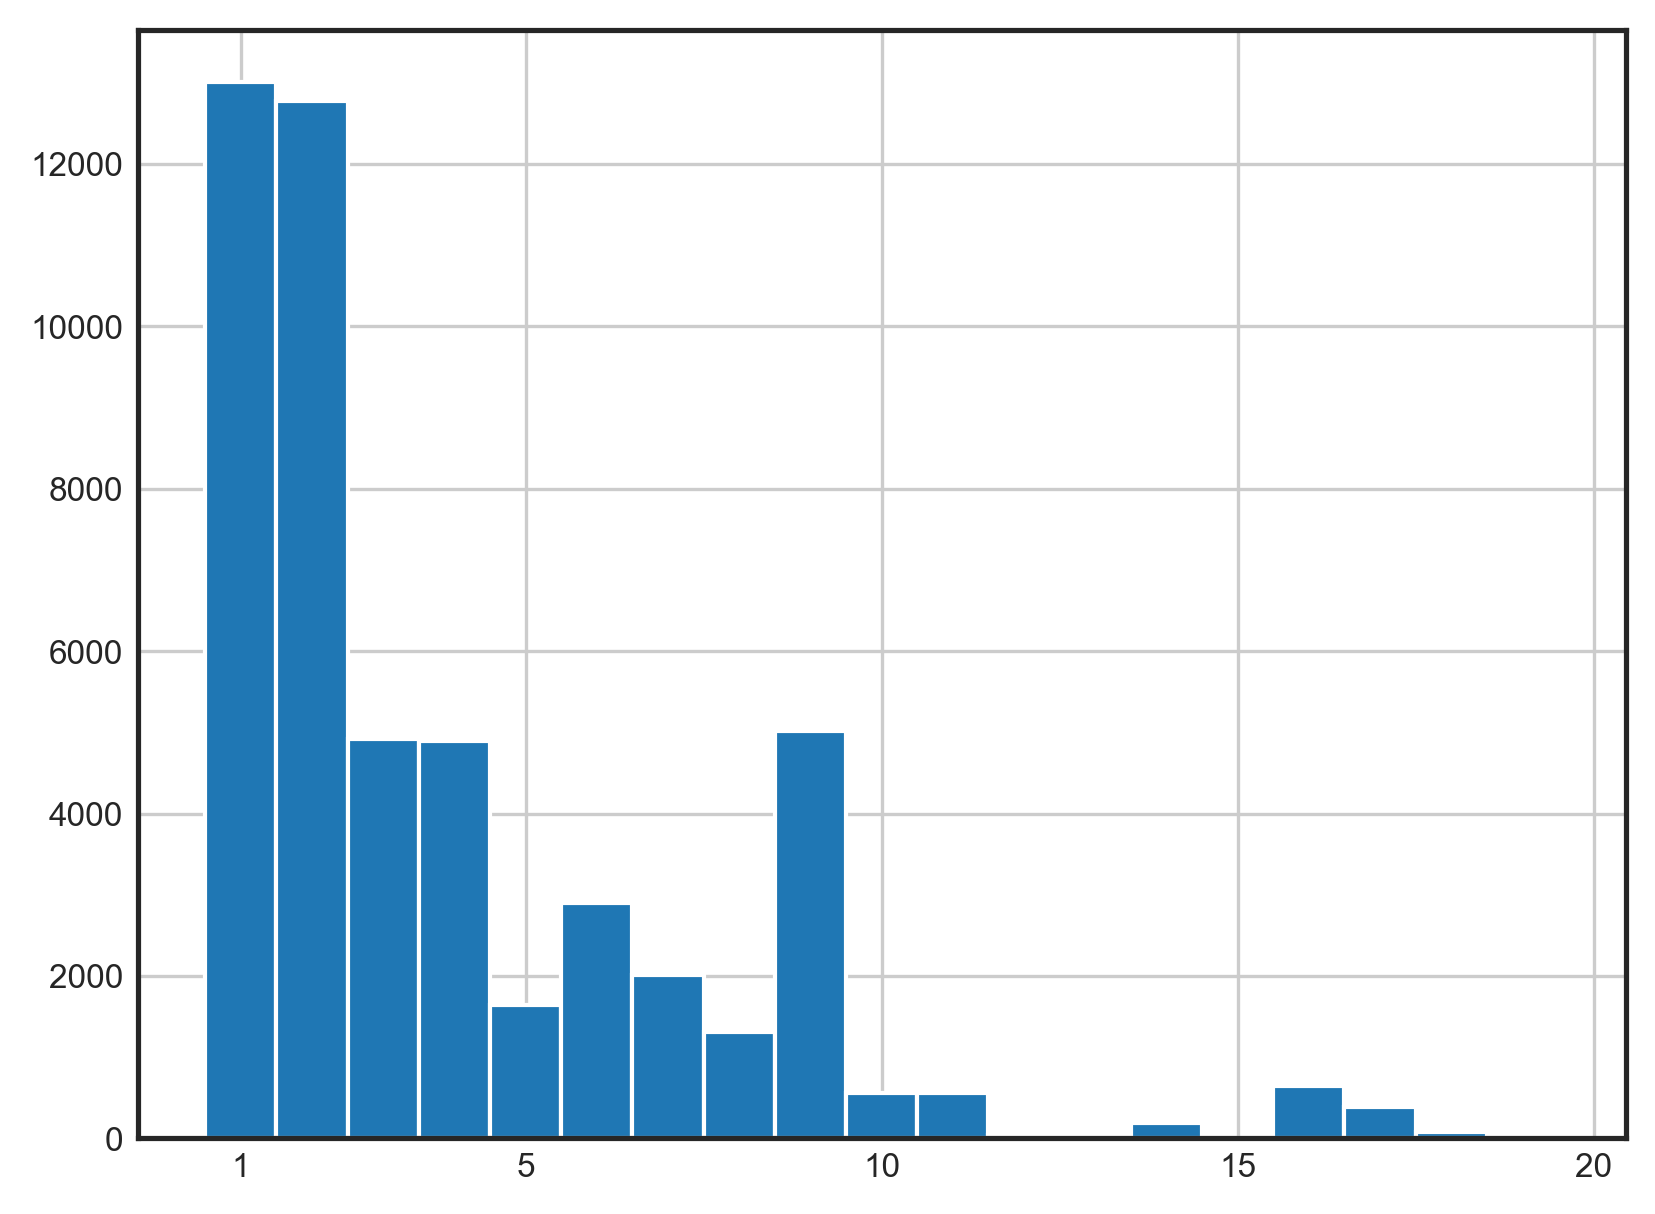

In [9]:
fig,ax=plt.subplots()
duration.hist(bins=[n+0.5 for n in range(0,20)],ax=ax)
ax.set_xticks([1,5,10,15,20])

In [10]:
# averigng post quem and ante quem
coins["date_avr"] = coins.apply(lambda row: (row["not_before"] + row["not_after"]) / 2, axis=1).round()

<AxesSubplot: xlabel='date_avr', ylabel='Density'>

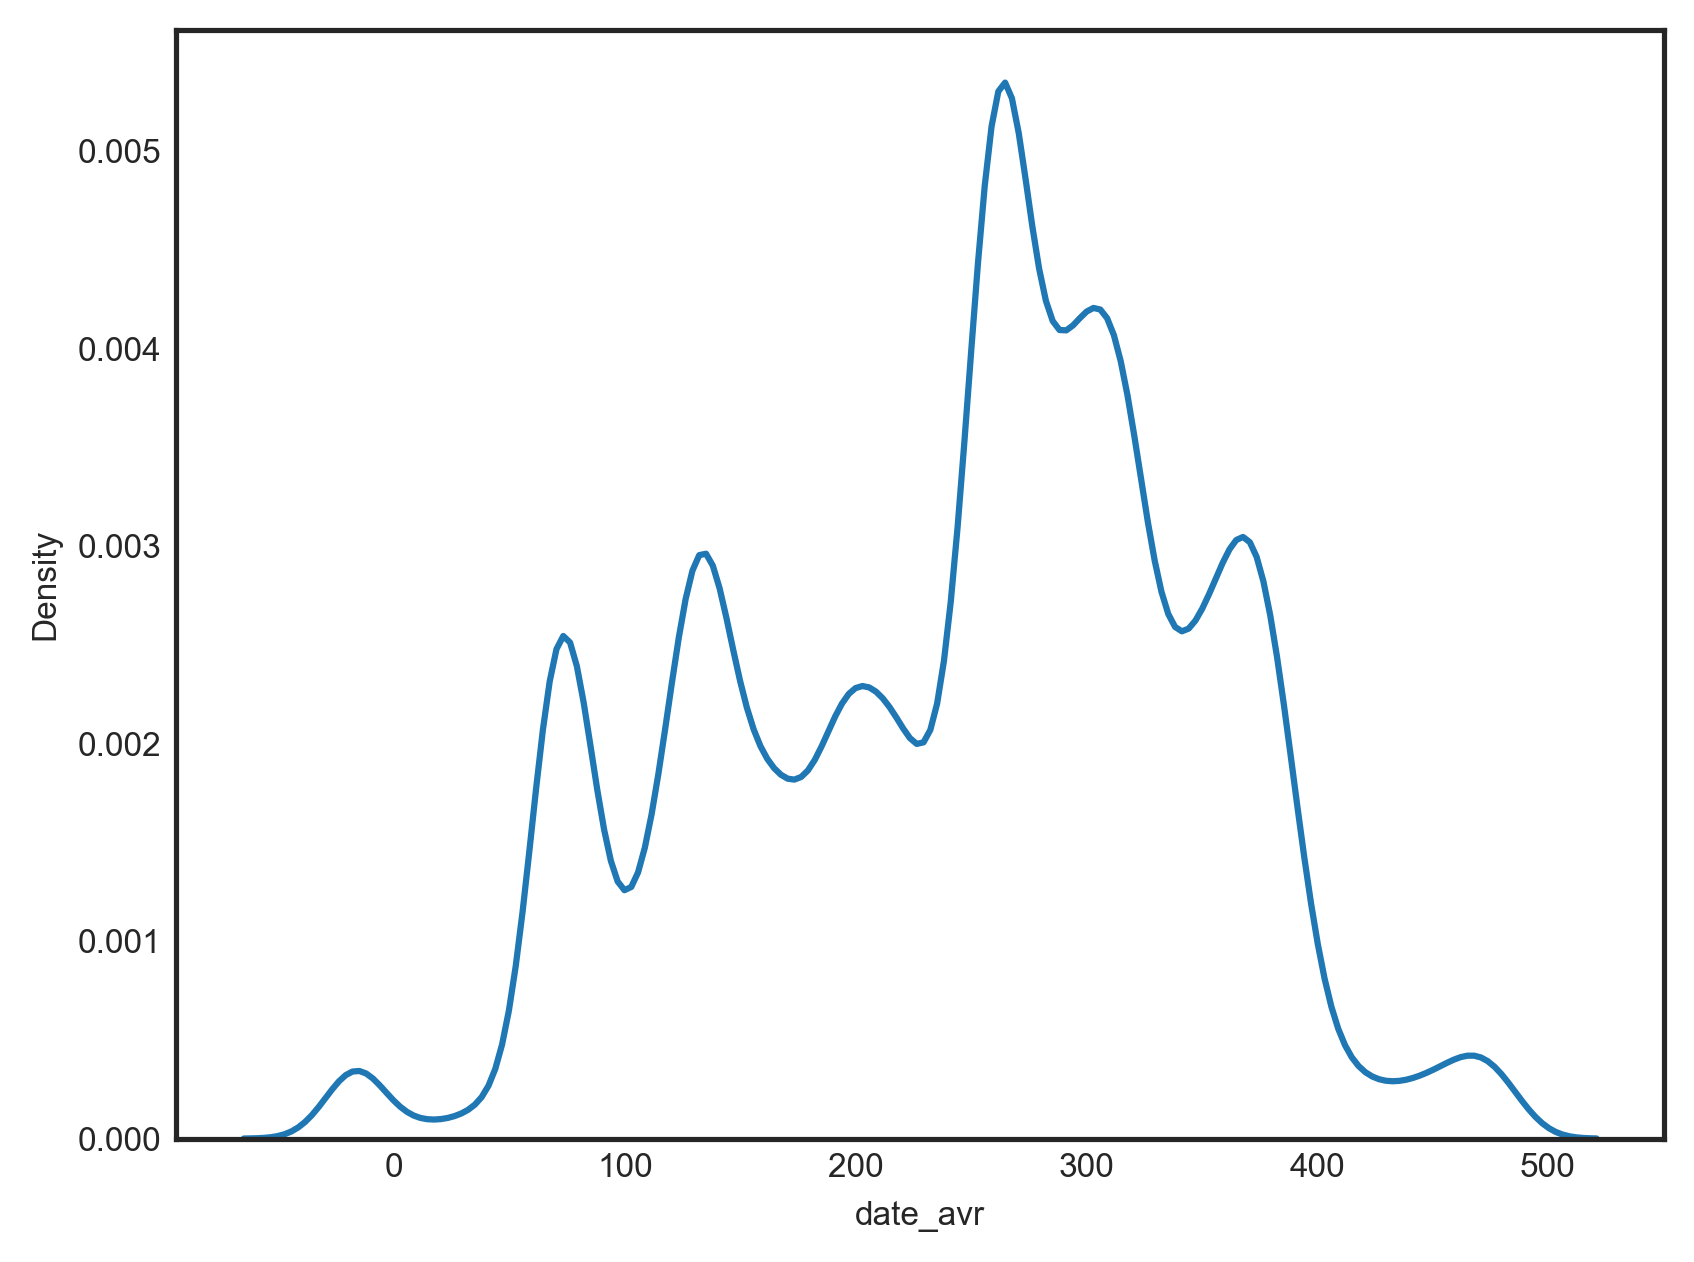

In [11]:
# plot overall temporal distribution by means of a KDE plot
sns.kdeplot(coins["date_avr"])

In [12]:
test_dates = coins["date_avr"].tolist()[:1000]
test_dates[:20]

[362.0,
 294.0,
 132.0,
 153.0,
 253.0,
 279.0,
 65.0,
 107.0,
 264.0,
 182.0,
 454.0,
 32.0,
 -30.0,
 132.0,
 80.0,
 148.0,
 310.0,
 264.0,
 272.0,
 272.0]

In [13]:
n = 246
buffer = 10

In [14]:
[d for d in test_dates if n-(buffer/2) <= d <= n+(buffer/2)][:20]

[248.0,
 250.0,
 243.0,
 250.0,
 250.0,
 251.0,
 246.0,
 248.0,
 250.0,
 242.0,
 251.0,
 250.0,
 250.0,
 246.0,
 242.0,
 247.0,
 242.0,
 250.0,
 244.0,
 251.0]

In [15]:
# function to count all types within a buffer (aka moving average)
def get_moving_avr(dates_data, buffer=10):
    diff = int(buffer / 2)
    dates_data = list(dates_data)
    date_min = int(np.nanmin(dates_data))
    date_max = int(np.nanmax(dates_data))
    #return date_max
    dates = [n for n in range(date_min + diff, date_max - diff)]
    counts = []
    for n in dates:
        counts.append((len([d for d in dates_data if n-diff <= d <= n+diff])))
    return dates, counts

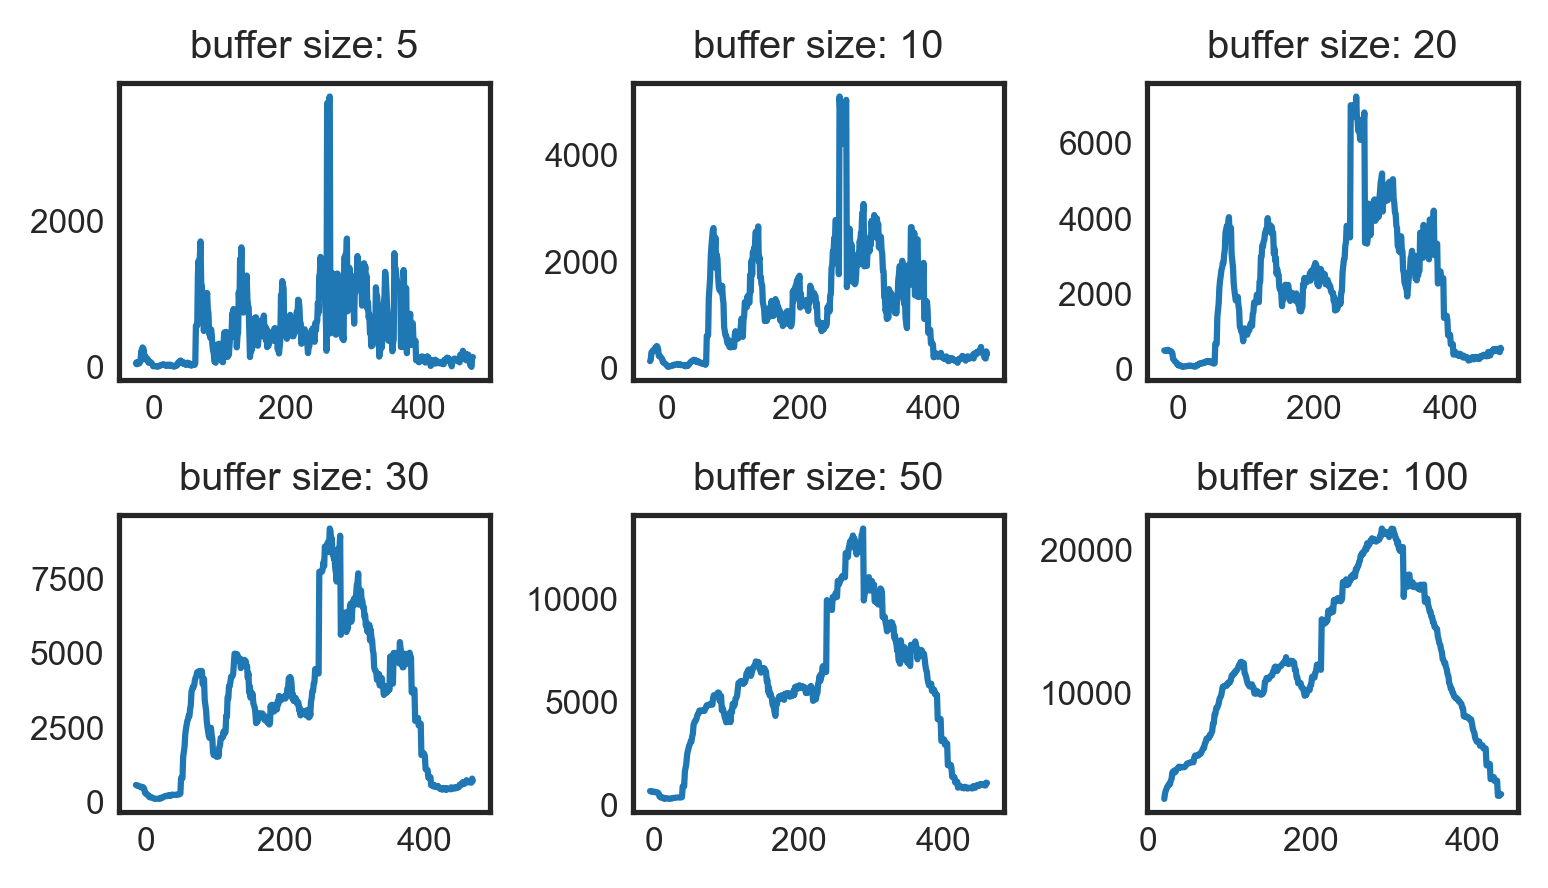

In [16]:
# plots of temporal distributions with different buffer sizes
buffer_sizes = [5, 10, 20, 30, 50, 100]

fig, axs = plt.subplots(2,3, figsize=(5.2, 3), dpi=300, tight_layout=True)
for buffer, ax in zip(buffer_sizes, axs.ravel()):
    moving_avr_data = get_moving_avr(coins["date_avr"], buffer)
    ax.plot(moving_avr_data[0], moving_avr_data[1])
    ax.set_title("buffer size: " + str(buffer))

In [17]:
len(coins)

51394

In [18]:
coins

,@id,@type,ontology#hasAuthority,ontology#hasDenomination,ontology#hasEndDate,ontology#hasManufacture,ontology#hasMaterial,ontology#hasMint,@id_obverse,ontology#hasRegion,...,ontology#hasLegend_obverse,ontology#hasPortrait_obverse,description_obverse,ontology#hasLegend_reverse,ontology#hasPortrait_reverse,description_reverse,ontology#hasControlmark_reverse,not_before,not_after,date_avr
0,http://numismatics.org/ocre/id/ric.8.cnp.157,"[http://nomisma.org/ontology#TypeSeriesItem, h...",julian_the_apostate,solidus,0363,struck,av,constantinople,ric.8.cnp.157#obverse,thrace,...,FL CL IVLIA-NVS PP AVG,julian_the_apostate,"Bust of Julian, pearl-diademed, draped, cuiras...",VIRTVS EXERCI-TVS ROMANORVM,,"Soldier, helmeted, draped, cuirassed, standing...",None,361.0,363.0,362.0
1,http://numismatics.org/ocre/id/ric.5.all.77,"[http://nomisma.org/ontology#TypeSeriesItem, h...",allectus,antoninianus,0296,struck,ar,camulodunum,ric.5.all.77#obverse,britannia,...,IMP C ALLECTVS P F AVG,allectus,"Bust of Allectus, radiate, cuirassed, right",LAETITI AVG,nomisma.rdf,"Laetitia, draped, standing left, holding wreat...",None,293.0,296.0,294.0
2,http://numismatics.org/ocre/id/ric.2_3(2).hdn....,"[http://nomisma.org/ontology#TypeSeriesItem, h...",hadrian,sestertius,0133,struck,orichalcum,rome,ric.2_3(2).hdn.1640#obverse,italy,...,HADRIANVS AVG COS III P P,hadrian,"Bust of Hadrian, laureate, draped and cuirasse...",S C (in field),nomisma.rdf,"Cappadocia, turreted, standing left, holding M...",None,130.0,133.0,132.0
3,http://numismatics.org/ocre/id/ric.3.ant.1405C_as,"[http://nomisma.org/ontology#TypeSeriesItem, h...",antoninus_pius,as,0161,struck,ae,rome,ric.3.ant.1405C_as#obverse,italy,...,FAVSTINA AVGVSTA AVG PII FIL,faustina_ii,"Bust of Faustina the Younger, draped, right, h...",S C,57039,"Diana, draped, standing front, head left, hold...",None,145.0,161.0,153.0
4,http://numismatics.org/ocre/id/ric.5.gall(1).255a,"[http://nomisma.org/ontology#TypeSeriesItem, h...",valerian,dupondius,0253,struck,ae,rome,ric.5.gall(1).255a#obverse,italy,...,IMP C P LIC GALLIENVS AVG,gallienus,"Bust of Gallienus, radiate, draped, right",LIBERALITAS AVG S C,59099,"Liberalitas, draped, standing left, holding te...",None,253.0,253.0,253.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51389,http://numismatics.org/ocre/id/ric.2_3(2).hdn.585,"[http://nomisma.org/ontology#TypeSeriesItem, h...",hadrian,aureus,0123,struck,av,rome,ric.2_3(2).hdn.585#obverse,italy,...,IMP CAESAR TRAIAN HADRIANVS AVG,hadrian,"Bust of Hadrian, laureate, draped and cuirasse...",P M TR P COS III,minerva,"Minerva standing left, holding spear; to left,...",None,121.0,123.0,122.0
51390,http://numismatics.org/ocre/id/ric.9.thes.27C.vi,"[http://nomisma.org/ontology#TypeSeriesItem, h...",valentinian_i,ae3,0375,struck,ae,thessalonica,ric.9.thes.27C.vi#obverse,macedonia,...,D N GRATIANVS P F AVG,gratian,"Bust of Gratian, pearl-diademed, draped and cu...",SECVRITAS-REIPVBLICAE,60915,"Victory advancing left, holding wreath and palm",None,367.0,375.0,371.0
51391,http://numismatics.org/ocre/id/ric.4.ss.111A,"[http://nomisma.org/ontology#TypeSeriesItem, h...",septimius_severus,denarius,0198,struck,ar,rome,ric.4.ss.111A#obverse,italy,...,L SEPT SEV PERT AVG IMP X,septimius_severus,"Head of Septimius Severus, laureate, right",IOVI CONSERVATORI,58921,"Jupiter, naked to waist, seated left on low se...",None,197.0,198.0,198.0
51392,http://numismatics.org/ocre/id/ric.6.tri.204,"[http://nomisma.org/ontology#TypeSeriesItem, h...",maximian,ae1,0297,struck,ae,treveri,ric.6.tri.204#obverse,gallia,...,CONSTANTIVS NOBIL C,constantius_chlorus,"Bust of Constantius Chlorus, laureate, cuirass...",GENIO POPV-LI ROMANI,,"Genius, wearing modius, nude, chlamys draped o...",None,296.0,297.0,296.0


In [19]:
coins.groupby("ontology#hasDenomination").size().sort_values(ascending=False)


ontology#hasDenomination
antoninianus                           9464
denarius                               6980
sestertius                             5287
aureus                                 4609
ae3                                    3827
                                       ... 
_:N55b16e0ef414433f9339844cfaaee7f5       1
_:N55c2345536c6472ab6da4e571332fe10       1
_:N55cb57d46dc94544ad6bcc1e2cb45c00       1
_:N55d90126d4a44d0d871f799d75a4fd7a       1
_:N8339800641724d8ea31b52ae6044f73c       1
Length: 3131, dtype: int64

In [20]:
cointypes = coins.groupby("ontology#hasDenomination").size().sort_values(ascending=False).index.tolist()
cointypes[:30]

['antoninianus',
 'denarius',
 'sestertius',
 'aureus',
 'ae3',
 'as',
 'dupondius',
 'solidus',
 'ae1',
 'ae2',
 'ae4',
 'siliqua',
 'quinarius',
 'large_ae2',
 'uncertain_value',
 '',
 'tremissis',
 'quinarius_aureus',
 'light_miliarensis',
 'multiple-gold',
 'quadrans',
 'semis',
 'small_ae2',
 'reduced_ae2',
 'semissis',
 'fraction',
 'heavy_miliarensis',
 'cistophorus',
 'roman_medallion',
 'half_siliqua']

In [21]:
cointypes = ['antoninianus', 'denarius', 'sestertius', 'aureus', 'as', 'dupondius', 'solidus', 'quinarius', 'quinarius_aureus']
cointypes

['antoninianus',
 'denarius',
 'sestertius',
 'aureus',
 'as',
 'dupondius',
 'solidus',
 'quinarius',
 'quinarius_aureus']

In [22]:
# how many denaries do we have?
coins = coins[coins["ontology#hasDenomination"].isin(cointypes)].copy()

In [23]:
len(coins)

34925

In [24]:
authorities_all_coins = coins.groupby("ontology#hasAuthority").size().sort_values(ascending=False)
authorities_all_coins

ontology#hasAuthority
hadrian              3468
gallienus            3396
antoninus_pius       2361
septimius_severus    2148
marcus_aurelius      1807
                     ... 
aureolus                2
zenobia                 2
saturninus              1
olybrius                1
domitian_ii             1
Length: 124, dtype: int64

In [26]:
coins.head(20)

,@id,@type,ontology#hasAuthority,ontology#hasDenomination,ontology#hasEndDate,ontology#hasManufacture,ontology#hasMaterial,ontology#hasMint,@id_obverse,ontology#hasRegion,...,ontology#hasLegend_obverse,ontology#hasPortrait_obverse,description_obverse,ontology#hasLegend_reverse,ontology#hasPortrait_reverse,description_reverse,ontology#hasControlmark_reverse,not_before,not_after,date_avr
0,http://numismatics.org/ocre/id/ric.8.cnp.157,"[http://nomisma.org/ontology#TypeSeriesItem, h...",julian_the_apostate,solidus,0363,struck,av,constantinople,ric.8.cnp.157#obverse,thrace,...,FL CL IVLIA-NVS PP AVG,julian_the_apostate,"Bust of Julian, pearl-diademed, draped, cuiras...",VIRTVS EXERCI-TVS ROMANORVM,,"Soldier, helmeted, draped, cuirassed, standing...",None,361.0,363.0,362.0
1,http://numismatics.org/ocre/id/ric.5.all.77,"[http://nomisma.org/ontology#TypeSeriesItem, h...",allectus,antoninianus,0296,struck,ar,camulodunum,ric.5.all.77#obverse,britannia,...,IMP C ALLECTVS P F AVG,allectus,"Bust of Allectus, radiate, cuirassed, right",LAETITI AVG,nomisma.rdf,"Laetitia, draped, standing left, holding wreat...",None,293.0,296.0,294.0
2,http://numismatics.org/ocre/id/ric.2_3(2).hdn....,"[http://nomisma.org/ontology#TypeSeriesItem, h...",hadrian,sestertius,0133,struck,orichalcum,rome,ric.2_3(2).hdn.1640#obverse,italy,...,HADRIANVS AVG COS III P P,hadrian,"Bust of Hadrian, laureate, draped and cuirasse...",S C (in field),nomisma.rdf,"Cappadocia, turreted, standing left, holding M...",None,130.0,133.0,132.0
3,http://numismatics.org/ocre/id/ric.3.ant.1405C_as,"[http://nomisma.org/ontology#TypeSeriesItem, h...",antoninus_pius,as,0161,struck,ae,rome,ric.3.ant.1405C_as#obverse,italy,...,FAVSTINA AVGVSTA AVG PII FIL,faustina_ii,"Bust of Faustina the Younger, draped, right, h...",S C,57039,"Diana, draped, standing front, head left, hold...",None,145.0,161.0,153.0
4,http://numismatics.org/ocre/id/ric.5.gall(1).255a,"[http://nomisma.org/ontology#TypeSeriesItem, h...",valerian,dupondius,0253,struck,ae,rome,ric.5.gall(1).255a#obverse,italy,...,IMP C P LIC GALLIENVS AVG,gallienus,"Bust of Gallienus, radiate, draped, right",LIBERALITAS AVG S C,59099,"Liberalitas, draped, standing left, holding te...",None,253.0,253.0,253.0
5,http://numismatics.org/ocre/id/ric.5.pro.91,"[http://nomisma.org/ontology#TypeSeriesItem, h...",probus,antoninianus,0282,struck,ar,lugdunum,ric.5.pro.91#obverse,gallia,...,IMP C PROBVS P F AVG,probus,"Bust of Probus, radiate, draped, right or bust...",PAX AVG,76227,"Pax, draped, standing left, holding olive-bran...",None,276.0,282.0,279.0
6,http://numismatics.org/ocre/id/ric.1(2).ner.431,"[http://nomisma.org/ontology#TypeSeriesItem, h...",nero,sestertius,0068,struck,ae,lugdunum,ric.1(2).ner.431#obverse,gallia,...,NERO CLAVD CAESAR AVG GER P M TR P IMP P P,nero,"Head of Nero, laureate, left; small globe at p...",ANNONA AVGVSTI CERES S C,nomisma.rdf,"Ceres, right, veiled and draped, seated left, ...",None,62.0,68.0,65.0
7,http://numismatics.org/ocre/id/ric.2.tr.566,"[http://nomisma.org/ontology#TypeSeriesItem, h...",trajan,sestertius,0111,struck,ae,rome,ric.2.tr.566#obverse,italy,...,IMP CAES NERVAE TRAIANO AVG GER DAC P M TR P C...,trajan,"Head of Trajan, laureate, right",S P Q R OPTIMO PRINCIPI S C,nomisma.rdf,"Dacia seated left, in attitude of mourning on ...",None,103.0,111.0,107.0
8,http://numismatics.org/ocre/id/ric.5.gall(2).206,"[http://nomisma.org/ontology#TypeSeriesItem, h...",gallienus,antoninianus,0268,struck,ar,rome,ric.5.gall(2).206#obverse,italy,...,GALLIENVS AVG,gallienus,,INDVLGENTIA AVG,178090,"Indulgentia, draped, legs crossed, leaning on ...",None,260.0,268.0,264.0
9,http://numismatics.org/ocre/id/ric.3.com.323Ba,"[http://nomisma.org/ontology#TypeSeriesItem, h...",commodus,sestertius,0182,struck,ae,rome,ric.3.com.323Ba#obverse,italy,...,M ANTONINVS COMMODVS AVG,commodus,"Head of Commodus, laureate, right",TR P VII IMP IIII COS III P P S C,59284,"Mars, helmeted, advancing right, holding trans...",None,181.0,182.0,182.0


# exploring description_reverse

In [27]:
ocre_deities = pd.read_csv("../data/coin_ocre_deities.csv")
ocre_deities

,Name
0,Abundantia
1,Achaea
2,Aeneas
3,Aequitas
4,Aeternitas
...,...
195,Vesta
196,Via Trajana
197,Victory
198,Virtus


In [28]:
deities_dict = {}
for deity_raw in ocre_deities["Name"].tolist():
    deity_list = deity_raw.replace(" (", "/").split("/")
    for deity_form in deity_list:
        deities_dict[deity_form] = deity_list[0]

# manual corrections:
deities_dict["Nike"] = "Victory"
deities_dict["Victoria"] = "Victory"

deities_tups = list(deities_dict.items())
deities_tups = sorted(deities_tups, key = lambda x: len(x[0]), reverse=True)
deities_tups[:10]

[('Genius of the Senate', 'Genius of the Senate'),
 ('Saeculum Frugiferum', 'Saeculum Frugiferum'),
 ('Genius of Lugdunum', 'Genius of Lugdunum'),
 ('Constantinopolis', 'Constantinopolis'),
 ('Fortuna Victrix', 'Fortuna Victrix'),
 ('Valeria Luperca', 'Valeria Luperca'),
 ('Diana Lucifera', 'Diana Lucifera'),
 ('Diana of Perge', 'Diana of Perge'),
 ('Bonus Eventus', 'Bonus Eventus'),
 ('Dea Caelestis', 'Dea Caelestis')]

In [29]:
test1 = "Fortuna, draped, standing left by wheel, holding rudder on globe in right hand and cornucopiae in left hand"
test2 = "Salus seated left, holding patera and with elbow rarely on Spes statue; to left, altar with snake coiled around"
test3 = "Ceres, right, veiled and draped, seated left, holding corn-ears and torch, facing Annona, draped, standing right, right hand resting on hip, left holding cornucopiae; in center, modius on garlanded altar right; behind, ship's stern"
test4 = "Annona standing, left, holding statue of Aequitas and cornucopiae; modius with corn-ears left; prow right"
test5 = "Annona, draped, standing left, holding statuette (of Concordia?) in right hand and cornucopiae in left hand; to left and right, modius with corn ears and ship, on which are two figures and Victory"

In [30]:
def extract_deities(description):
    deities_found = []
    for tup in deities_tups:
        if tup[0] in description:
            if len(re.findall("(\W|^)" + tup[0] + "(\W|$)", description)) > 0:
                deities_found.append(tup[1])
                description = re.sub("(\W|^)(" + tup[0] + ")(\W|$)", r"\1", description)
    return deities_found

In [31]:
extract_deities(test3)

['Annona', 'Ceres']

In [32]:
# extract entities (e.g. Fortuna etc.) from "description_reverse"
coins["deities"] = coins["description_reverse"].apply(extract_deities)

In [36]:
bool([])

False

In [37]:
coins[(coins["description_reverse"].apply(lambda x: x.lower()).str.contains("altar")) & ~coins["deities"].apply(bool)] #["ontology#hasLegend_reverse"].apply(lambda x: x.lower()).str.contains("altar")

,@id,@type,ontology#hasAuthority,ontology#hasDenomination,ontology#hasEndDate,ontology#hasManufacture,ontology#hasMaterial,ontology#hasMint,@id_obverse,ontology#hasRegion,...,ontology#hasPortrait_obverse,description_obverse,ontology#hasLegend_reverse,ontology#hasPortrait_reverse,description_reverse,ontology#hasControlmark_reverse,not_before,not_after,date_avr,deities
21,http://numismatics.org/ocre/id/ric.5.gall(1).124,"[http://nomisma.org/ontology#TypeSeriesItem, h...",valerian,antoninianus,0259,struck,ar,rome,ric.5.gall(1).124#obverse,italy,...,gallienus,"Head of Gallienus, radiate, right",P M TR P VII COS,gallienus,"Gallienus, togate, sacrificing at altar out of...",None,259.0,259.0,259.0,[]
128,http://numismatics.org/ocre/id/ric.5.gall(1).447c,"[http://nomisma.org/ontology#TypeSeriesItem, h...",valerian,antoninianus,0256,struck,ar,asia,ric.5.gall(1).447c#obverse,asia,...,gallienus,"Bust of Gallienus, radiate, draped, cuirassed,...",PIETAS AVGG,gallienus,"Gallienus and Valerian, standing face to face,...",None,255.0,256.0,256.0,[]
142,http://numismatics.org/ocre/id/ric.3.ant.292A_...,"[http://nomisma.org/ontology#TypeSeriesItem, h...",antoninus_pius,denarius,0159,struck,ar,rome,ric.3.ant.292A_denarius#obverse,italy,...,antoninus_pius,"Head of Antoninus Pius, laureate, right",VOTA SOL DECENN II COS IIII,antoninus_pius,"Antoninus Pius, veiled, togate. standing left,...",None,158.0,159.0,158.0,[]
172,http://numismatics.org/ocre/id/ric.4.sa.401,"[http://nomisma.org/ontology#TypeSeriesItem, h...",severus_alexander,sestertius,0223,struck,ae,rome,ric.4.sa.401#obverse,italy,...,severus_alexander,"Bust of Severus Alexander, laureate, draped, r...",P M TR P II COS P P S C,,"Severus Alexander, veiled, togate, standing le...",None,223.0,223.0,223.0,[]
423,http://numismatics.org/ocre/id/ric.1(2).aug.247,"[http://nomisma.org/ontology#TypeSeriesItem, h...",augustus,sestertius,0014,struck,ae,lugdunum,ric.1(2).aug.247#obverse,gallia,...,tiberius,"Head of Tiberius, bare, left",ROM ET AVG,60915,"Altar highly decorated with corona civica, lau...",None,12.0,14.0,13.0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50537,http://numismatics.org/ocre/id/ric.4.crl.325,"[http://nomisma.org/ontology#TypeSeriesItem, h...",caracalla,denarius,0222,struck,ar,rome,ric.4.crl.325#obverse,italy,...,caracalla,"Head of Caracalla, laureate, right",VOTA SVSCEPTA X,caracalla,"Caracalla, veiled, togate, standing left, sacr...",None,210.0,222.0,216.0,[]
50664,http://numismatics.org/ocre/id/ric.1(2).aug.229,"[http://nomisma.org/ontology#TypeSeriesItem, h...",augustus,sestertius,-0010,struck,ae,lugdunum,ric.1(2).aug.229#obverse,gallia,...,augustus,"Head of Augustus, laureate, right",ROM ET AVG,60915,"Altar highly decorated with corona civica, lau...",None,-15.0,-10.0,-12.0,[]
50696,http://numismatics.org/ocre/id/ric.2_1(2).dom.282,"[http://nomisma.org/ontology#TypeSeriesItem, h...",domitian,sestertius,0085,struck,ae,rome,ric.2_1(2).dom.282#obverse,italy,...,domitian,"Bust of Domitian, laureate, right with aegis",S C,domitian,Domitian standing right clasping hands with of...,None,85.0,85.0,85.0,[]
50784,http://numismatics.org/ocre/id/ric.5.tet_i.149,"[http://nomisma.org/ontology#TypeSeriesItem, h...",tetricus_i,antoninianus,0274,struck,ar,southern_gallic_mint,ric.5.tet_i.149#obverse,gallia,...,tetricus_i,"Bust of Tetricus I, radiate, draped, right",VOTA PVBLICA,,Altar,None,271.0,274.0,272.0,[]


In [ ]:
coins["ontology#hasLegend_reverse"]

In [40]:
ocre_deities

,Name
0,Abundantia
1,Achaea
2,Aeneas
3,Aequitas
4,Aeternitas
...,...
195,Vesta
196,Via Trajana
197,Victory
198,Virtus


In [47]:
def get_deity_candidates(legend_reverse):
    candidates = []
    for deity in ocre_deities["Name"]:
        deity_4gram = deity.replace("u", "v")[:4].lower()
        if deity_4gram in legend_reverse.lower():
            candidates.append(deity)
    return candidates
coins["deities_candidates"] = coins["ontology#hasLegend_reverse"].apply(get_deity_candidates)

In [52]:
coins

,@id,@type,ontology#hasAuthority,ontology#hasDenomination,ontology#hasEndDate,ontology#hasManufacture,ontology#hasMaterial,ontology#hasMint,@id_obverse,ontology#hasRegion,...,description_obverse,ontology#hasLegend_reverse,ontology#hasPortrait_reverse,description_reverse,ontology#hasControlmark_reverse,not_before,not_after,date_avr,deities,deities_candidates
0,http://numismatics.org/ocre/id/ric.8.cnp.157,"[http://nomisma.org/ontology#TypeSeriesItem, h...",julian_the_apostate,solidus,0363,struck,av,constantinople,ric.8.cnp.157#obverse,thrace,...,"Bust of Julian, pearl-diademed, draped, cuiras...",VIRTVS EXERCI-TVS ROMANORVM,,"Soldier, helmeted, draped, cuirassed, standing...",None,361.0,363.0,362.0,[],"[Roma, Virtus]"
1,http://numismatics.org/ocre/id/ric.5.all.77,"[http://nomisma.org/ontology#TypeSeriesItem, h...",allectus,antoninianus,0296,struck,ar,camulodunum,ric.5.all.77#obverse,britannia,...,"Bust of Allectus, radiate, cuirassed, right",LAETITI AVG,nomisma.rdf,"Laetitia, draped, standing left, holding wreat...",None,293.0,296.0,294.0,[Laetitia],[Laetitia]
2,http://numismatics.org/ocre/id/ric.2_3(2).hdn....,"[http://nomisma.org/ontology#TypeSeriesItem, h...",hadrian,sestertius,0133,struck,orichalcum,rome,ric.2_3(2).hdn.1640#obverse,italy,...,"Bust of Hadrian, laureate, draped and cuirasse...",S C (in field),nomisma.rdf,"Cappadocia, turreted, standing left, holding M...",None,130.0,133.0,132.0,[Cappadocia],[]
3,http://numismatics.org/ocre/id/ric.3.ant.1405C_as,"[http://nomisma.org/ontology#TypeSeriesItem, h...",antoninus_pius,as,0161,struck,ae,rome,ric.3.ant.1405C_as#obverse,italy,...,"Bust of Faustina the Younger, draped, right, h...",S C,57039,"Diana, draped, standing front, head left, hold...",None,145.0,161.0,153.0,[Diana],[]
4,http://numismatics.org/ocre/id/ric.5.gall(1).255a,"[http://nomisma.org/ontology#TypeSeriesItem, h...",valerian,dupondius,0253,struck,ae,rome,ric.5.gall(1).255a#obverse,italy,...,"Bust of Gallienus, radiate, draped, right",LIBERALITAS AVG S C,59099,"Liberalitas, draped, standing left, holding te...",None,253.0,253.0,253.0,[Liberalitas],"[Liber, Liberalitas, Libertas]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51387,http://numismatics.org/ocre/id/ric.5.cara.442,"[http://nomisma.org/ontology#TypeSeriesItem, h...",carausius,antoninianus,0293,struck,ar,camulodunum,ric.5.cara.442#obverse,britannia,...,"Bust of Carausius, radiate, draped, cuirassed,...",VIRTVS AVGG,59284,"Mars, standing left, placing right hand on shi...",None,286.0,293.0,290.0,[Mars],[Virtus]
51388,http://numismatics.org/ocre/id/ric.5.car.207,"[http://nomisma.org/ontology#TypeSeriesItem, h...",carus,antoninianus,0283,struck,ar,antiocheia_syria,ric.5.car.207#obverse,syria,...,"Bust of Carinus, radiate, cuirassed, right",VIRTVS AVGG,carinus,"Carinus, draped, cuirassed, standing right, ho...",None,282.0,283.0,282.0,"[Jupiter, Victory]",[Virtus]
51389,http://numismatics.org/ocre/id/ric.2_3(2).hdn.585,"[http://nomisma.org/ontology#TypeSeriesItem, h...",hadrian,aureus,0123,struck,av,rome,ric.2_3(2).hdn.585#obverse,italy,...,"Bust of Hadrian, laureate, draped and cuirasse...",P M TR P COS III,minerva,"Minerva standing left, holding spear; to left,...",None,121.0,123.0,122.0,[Minerva],[]
51391,http://numismatics.org/ocre/id/ric.4.ss.111A,"[http://nomisma.org/ontology#TypeSeriesItem, h...",septimius_severus,denarius,0198,struck,ar,rome,ric.4.ss.111A#obverse,italy,...,"Head of Septimius Severus, laureate, right",IOVI CONSERVATORI,58921,"Jupiter, naked to waist, seated left on low se...",None,197.0,198.0,198.0,"[Jupiter, Victory]","[Constantia, Constantinopolis]"


In [54]:
coins_candidates = coins[(coins["description_reverse"].apply(lambda x: x.lower()).str.contains("altar")) & ~coins["deities"].apply(bool) & coins["deities_candidates"].apply(bool)][["@id", "ontology#hasLegend_reverse", "deities_candidates", "description_reverse"]]
coins_candidates.to_csv("../data/coins_candidates_coding.csv")

In [32]:
deities_freqs = nltk.FreqDist([d for l in coins["deities"] for d in l])
deities_freqs.most_common(20)

[('Victory', 5375),
 ('Jupiter', 1361),
 ('Pax', 1326),
 ('Mars', 1317),
 ('Roma', 1286),
 ('Fortuna', 1110),
 ('Felicitas', 972),
 ('Providentia', 928),
 ('Concordia', 895),
 ('Salus', 839),
 ('Minerva', 832),
 ('Sol', 790),
 ('Liberalitas', 675),
 ('Aequitas', 613),
 ('Spes', 612),
 ('Hercules', 560),
 ('Pietas', 554),
 ('Fides', 534),
 ('Genius', 484),
 ('Securitas', 480)]

In [33]:
deities_freqs_df = pd.DataFrame(deities_freqs.most_common())

In [34]:
deities_freqs_df.to_csv("../data/deities_freqs_df.csv")

In [35]:
coins.to_csv("../data/coins_deities_df.csv")
coins.to_parquet("../data/coins_deities_df.parquet")